# `dask` Experiments on SalishSeaCast Results

This notebook explores how to use `dask` and `xarray.open_mfdataset()` to
improve the performance of operations on multiple day's SalishSeaCast results files.

The packages required by this notebook are defined in the `conda` environment file `analysis-doug/notebooks/dask-expts/environment.yaml` along with instructions on how to created an isolated environment containing the latest versions of those packages.
The `analysis-doug/notebooks/dask-expts/requirements.txt` contains a complete list of all of the packages (top level and dependecies) and their versions that were used most recently for work in this notebook. 

To get some serious compute muscle,
I run this Jupyter Lab headless on port 9999 on `salish` with:

  jupyter lab --no-browser --port=9999
   
and set up an `ssh` tunnel to connect to the kernel on port 9999 on `salish` from my local machine's port 4343 with:

  ssh -N -L 4343:localhost:9999 salish
  
and finally launch the lab UI in my local browser with:

  http://localhost:4343/

## Setup

Show `matplotlib` images inline,
and do Python imports.

In [1]:
%matplotlib inline

In [2]:
import functools
from pathlib import Path
import sys
import time

import arrow
import dask
import dask.distributed
import netCDF4
import xarray

Python and library versions:

In [3]:
print(f"Python {sys.version=}")
print(f"{xarray.__version__=}")
print(f"{dask.__version__=}")
print(f"{netCDF4.__version__=}")
print(f"{arrow.__version__=}")

Python sys.version='3.8.0 | packaged by conda-forge | (default, Nov  6 2019, 23:20:36) \n[GCC 7.3.0]'
xarray.__version__='0.14.0'
dask.__version__='2.7.0'
netCDF4.__version__='1.5.3'
arrow.__version__='0.15.4'


## Choose a Calculation for Experiments

We want a non-trivial calculation that we can do across multiple days of 
SalishSeaCast output so that we can test performance time of different
ways of doing the calculation.
But we don't want the calculation to take so long that interactive
experiments are annoying.

Let's try a naive depth average of salinity for a small region of the domain.
It's naive because we are not going to properly account for grid layer thickness
(`e3t`) and bathymetry.

Load a `grid_T` dataset:

In [4]:
ds_path = Path("/results2/SalishSea/nowcast-green.201812/01jan15/SalishSea_1h_20150101_20150101_grid_T.nc")

In [5]:
ds = xarray.open_dataset(ds_path)    
ds

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, deptht: 40, nvertex: 4, time_counter: 24, x: 398, y: 898)
Coordinates:
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
  * deptht                (deptht) float32 0.5000003 1.5000031 ... 441.4661
    time_centered         (time_counter) datetime64[ns] ...
  * time_counter          (time_counter) datetime64[ns] 2015-01-01T00:30:00 ... 2015-01-01T23:30:00
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    bounds_lon            (y, x, nvertex) float32 ...
    bounds_lat            (y, x, nvertex) float32 ...
    area                  (y, x) float32 ...
    deptht_bounds         (deptht, axis_nbounds) float32 ...
    sossheig              (time_counter, y, x) float32 ...
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] ...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] ...
    votemper              (time_counter, dept

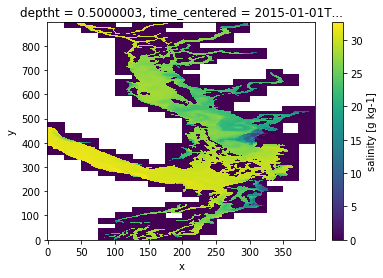

In [6]:
ds.vosaline.isel(time_counter=0, deptht=0).plot()

Zoom in to a patch south of Victoria:

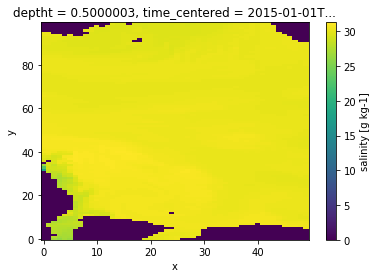

In [7]:
ds.vosaline.isel(time_counter=0, deptht=0, y=slice(200, 300), x=slice(200,250)).plot()

Calculate and plot the naive depth averaged salinity for the first time step in the dataset:

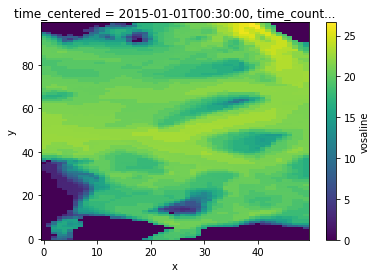

In [8]:
ds.vosaline.isel(time_counter=0, y=slice(200, 300), x=slice(200,250)).mean(dim="deptht").plot()

Time the calculation of the depth averaged salinity for all time steps in the dataset:

In [9]:
%%time
depth_avgs = ds.vosaline.isel(y=slice(200, 300), x=slice(200,250)).mean(dim="deptht")
depth_avgs

CPU times: user 3.72 s, sys: 1.16 s, total: 4.88 s
Wall time: 4.88 s


<xarray.DataArray 'vosaline' (time_counter: 24, y: 100, x: 50)>
array([[[0.       , 0.       , 7.462555 , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 4.382652 , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        ...,
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ]],

       [[0.       , 0.       , 7.450681 , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 4.374125 , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        ...,
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        

Close the dataset because we want to include file access in our timing for future tests.

In [10]:
ds.close()

## A Digression About Timing

The `%%time` cell magic used above is fine when the calculations actually happen
when the cell is executed.
But for `dask` operations the calculations are deferred and `%%time` just shows
us the time it takes to add the deferred calculations to the `dask` operations graph -
that's not what we're interested in.

So, we need to do our timing explicitly:

In [11]:
t_start = time.time()
with xarray.open_dataset(ds_path) as ds:
    depth_avgs = ds.vosaline.isel(y=slice(200, 300), x=slice(200,250)).mean(dim="deptht")
t_end = time.time()
print(t_end - t_start)

4.957032203674316


Adding the `t_start`, `t_end`, and `print(...` to every cell gets really annoying.
Instead we'll create a timing decorator to do that and write the things we want timed
as decorated functions.

The timing decorator is:

In [12]:
def function_timer(func):
    @functools.wraps(func)
    def wrapper_function_timer(*args, **kwargs):
        t_start = time.time()
        return_value = func(*args, **kwargs)
        t_end = time.time()
        print(f"{t_end - t_start}s")
        return return_value

    return wrapper_function_timer

For more details about functions within functions,
decorators,
and `functools.wraps()`,
please see https://realpython.com/primer-on-python-decorators/

Now we can re-write our explicitly timed call above as a decorated function
and get its execution time printed when we call the function:

In [13]:
@function_timer
def depth_avgs_from_one_file(ds_path):
    with xarray.open_dataset(ds_path) as ds:
        depth_avgs = ds.vosaline.isel(y=slice(200, 300), x=slice(200,250)).mean(dim="deptht")
    return depth_avgs

In [14]:
depth_avgs = depth_avgs_from_one_file(ds_path)
depth_avgs.shape

5.186700344085693s


(24, 100, 50)

## Using `dask.distributed`

The recommended way to use `dask` to run `xarray` calculations in parallel, 
even for local calculations,
is via `dask.distributed`
(https://docs.dask.org/en/latest/scheduling.html#dask-distributed-local).

Let's start a local cluster on `salish` with 12 workers that each can use up to 2 threads,
and tell the cluster scheduler to use processes instead of threads.

There's some room for exploration of how to best tune the choices of workers, 
threads per worker,
and whether to use processes or threads.
The number of workers should be less than or equal to the number of not-busy cores.

At the time when the tests in this notebook were run,
`salish` was not running `nowcast-dev` and only one other CPU-bound process was running.
Experiments showed that 12 workers gave the best performance under those conditions.
Experiments also showed that 2 threads per worker gave the best performance.
10 threads per worker is apparently a reasonable choice for Python code.
Putting the workers in processes rather than in threads was definitely faster.

The number of workers can be adjusted in a running cluster with `client.cluster.scale(n_workers)`.
To change the threads per worker, or processes, the cluster has to be
stopped with `client.close()` and restarted.

In [15]:
client = dask.distributed.Client(
    n_workers=12, threads_per_worker=2, processes=True)
client

Client Scheduler: tcp://127.0.0.1:41669 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 12 Cores: 24 Memory: 270.46 GB


You can set up an `ssh` tunnel,
similar to what you do for the Jupyter Lab UI,
to access the `dask.distributed.Client` dashboard at the URL above
to monitor and gain insight into how the cluster is executing operations.

Passing a `chunks` dict to `xarray.open_dataset()` causes the variables
to be setup as `dask` arrays with the chunk sizes given in the dict.

Note that this doesn't load the dataset into memory.
Instead, it sets up the `dask` data structures so that operations
on the dataset will be lazily evaluated and added to the `dask` task graph
for later execution by the client workers.

In [16]:
ds = xarray.open_dataset(
    ds_path,
    chunks={"time_counter": 1, "deptht": 40, "y": 898, "x": 398}
)
ds

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, deptht: 40, nvertex: 4, time_counter: 24, x: 398, y: 898)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(898, 398), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(898, 398), meta=np.ndarray>
  * deptht                (deptht) float32 0.5000003 1.5000031 ... 441.4661
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2015-01-01T00:30:00 ... 2015-01-01T23:30:00
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    bounds_lon            (y, x, nvertex) float32 dask.array<chunksize=(898, 398, 4), meta=np.ndarray>
    bounds_lat            (y, x, nvertex) float32 dask.array<chunksize=(898, 398, 4), meta=np.ndarray>
    area                  (y, x) float32 dask.array<chunksize=(898, 398), meta=np.ndarray>
    deptht_bounds         (deptht, ax

Displaying the `data` attribute of a variable gives a visualization of the `dask.array` associated with it.

In [17]:
ds.vosaline.data

dask.array<open_dataset-daa3722aecff4435a38932873cb7ea67vosaline, shape=(24, 40, 898, 398), dtype=float32, chunksize=(1, 40, 898, 398), chunktype=numpy.ndarray>

We can set up a naive depth averaged salinity calculation 
the same way we did without `dask`,
but the result is a "promise" to do the calculation.
To actually do the calculation, call the `compute()` method on the "promise".

In [18]:
depth_avgs = ds.vosaline.isel(y=slice(200, 300), x=slice(200,250)).mean(dim="deptht")
depth_avgs

<xarray.DataArray 'vosaline' (time_counter: 24, y: 100, x: 50)>
dask.array<mean_agg-aggregate, shape=(24, 100, 50), dtype=float32, chunksize=(1, 100, 50), chunktype=numpy.ndarray>
Coordinates:
    nav_lat        (y, x) float32 dask.array<chunksize=(100, 50), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(100, 50), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2015-01-01T00:30:00 ... 2015-01-01T23:30:00
Dimensions without coordinates: y, x

In [19]:
depth_avgs.compute()

<xarray.DataArray 'vosaline' (time_counter: 24, y: 100, x: 50)>
array([[[0.       , 0.       , 7.462555 , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 4.382652 , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        ...,
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ]],

       [[0.       , 0.       , 7.450681 , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 4.374125 , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        ...,
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        

Let's set up a timing-decorated function to experiment with chunking:

In [20]:
@function_timer
def depth_avgs_via_dask(ds_path, chunks):
    with xarray.open_dataset(ds_path, chunks=chunks) as ds:
        depth_avgs = ds.vosaline.isel(y=slice(200, 300), x=slice(200,250)).mean(dim="deptht")
        return depth_avgs.compute()

`chunks=None` is the same as not using `dask`.

In [21]:
chunks = None
depth_avgs = depth_avgs_via_dask(ds_path, chunks)
depth_avgs.shape

5.197296619415283s


(24, 100, 50)

Passing an empty `dict` for `chunks` causes the entire dataset to be
treated as a single chunk.
That doesn't offer much, if any, performance improvement over not using `dask`.
It would probably also result in an out-of-memory failure if used with
`xarray.open_mfdataset()` and a large number of files.

In [22]:
ds = xarray.open_dataset(ds_path, chunks={})
ds.vosaline.data

dask.array<open_dataset-632cfa33b65ea803bc00313df959b0b7vosaline, shape=(24, 40, 898, 398), dtype=float32, chunksize=(24, 40, 898, 398), chunktype=numpy.ndarray>

In [23]:
ds.close()

If we look at a results file with `ncdump -cst` we see for the `vosaline` variable:

    float vosaline(time_counter, deptht, y, x) ;
        vosaline:standard_name = "sea_water_reference_salinity" ;
        vosaline:long_name = "salinity" ;
        vosaline:units = "g kg-1" ;
        vosaline:online_operation = "average" ;
        vosaline:interval_operation = "40 s" ;
        vosaline:interval_write = "1 h" ;
        vosaline:cell_methods = "time: mean (interval: 40 s)" ;
        vosaline:cell_measures = "area: area" ;
        vosaline:_FillValue = 1.e+20f ;
        vosaline:missing_value = 1.e+20f ;
        vosaline:coordinates = "time_centered deptht nav_lat nav_lon" ;
        vosaline:_Storage = "chunked" ;
        vosaline:_ChunkSizes = 1, 40, 898, 398 ;
        vosaline:_Shuffle = "true" ;
        vosaline:_Endianness = "little" ;

which gives us 2 pieces of information that help us decided what to use for `chunks`.
One is the `_ChunkSizes` special attribute value of `1, 40, 898, 398`.
The other is the variable type of `float` which means a 32-bit (4-byte) floating point number.

Let's try matching the `chunks` dict to `_ChunkSizes`:

In [24]:
chunks = {"time_counter": 1, "deptht": 40, "y": 898, "x": 398}
ds = xarray.open_dataset(ds_path, chunks=chunks)
ds.vosaline.data

dask.array<open_dataset-daa3722aecff4435a38932873cb7ea67vosaline, shape=(24, 40, 898, 398), dtype=float32, chunksize=(1, 40, 898, 398), chunktype=numpy.ndarray>

In [25]:
ds.close()

The chunk size in bytes comes from our `_ChunksSizes` and the fact that `float` is 4 bytes:

In [26]:
1 * 40 * 898 * 398 * 4 / 1000 / 1000

57.18464

and we get a big boost in performance using that chunking:

In [27]:
chunks = {"time_counter": 1, "deptht": 40, "y": 898, "x": 398}
depth_avgs = depth_avgs_via_dask(ds_path, chunks)
depth_avgs.shape

0.7656090259552002s


(24, 100, 50)

The `dask` Best Practices docs
(https://docs.dask.org/en/latest/array-best-practices.html)
suggest that chunks should be on the order of hundreds of MB,
and oriented to match the data storage format.
So, let's try scaling our chunk size:

In [28]:
for factor in (1, 1.5, 2, 2.5, 3):
    chunk_size = factor *1 * 40 * 898 * 398 * 4 / 1000 / 1000
    print(f"{factor=}, {chunk_size=}MB")
    chunks = {"time_counter": int(1*factor), "deptht": 40*factor, "y": 898*factor, "x": 398*factor}
    depth_avgs = depth_avgs_via_dask(ds_path, chunks)
    depth_avgs.shape

factor=1, chunk_size=57.18464MB
1.024073839187622s
factor=1.5, chunk_size=85.77696MB
0.9643673896789551s
factor=2, chunk_size=114.36928MB
0.7084102630615234s
factor=2.5, chunk_size=142.9616MB
1.0661101341247559s
factor=3, chunk_size=171.55392MB
1.4465858936309814s


Running this cell multiple times gives different suggests for what is the best chunk size
because the time values are so small.
So, at this point let's stick with 

  `chunks = {"time_counter": 1, "deptht": 40, "y": 898, "x": 398}`.

## Processing Multiple Day's Results Files

First we'll loop over multiple day's `grid_T` files without `dask`,
calculating `depth_avgs` from each,
then concatenating them together for the final result.

In [29]:
@function_timer
def depth_avgs_from_files(ds_paths):
    day_depth_avgs = []
    for ds_path in ds_paths:
        with xarray.open_dataset(ds_path) as ds:
            day_depth_avgs.append(
                ds.vosaline.isel(
                    y=slice(200, 300), x=slice(200,250)).mean(dim="deptht"))
    return xarray.concat(day_depth_avgs, dim="time_counter")

We're going to need lists of dataset file paths,
so let's create a function to calculate those for us:

In [30]:
def calc_ds_paths(
    start_date, n_days, ng=Path("/results2/SalishSea/nowcast-green.201812")
):
    ds_paths = []
    for day in arrow.Arrow.range("day", start_date, limit=n_days):
        ddmmmyy = day.format("DDMMMYY").lower()
        yyyymmdd = day.format("YYYYMMDD")
        ds_paths.append(
            ng/Path(f"{ddmmmyy}", f"SalishSea_1h_{yyyymmdd}_{yyyymmdd}_grid_T.nc")
        )
    return ds_paths

In [31]:
ds_paths = calc_ds_paths(arrow.get("2015-01-01"), n_days=2)
depth_avgs = depth_avgs_from_files(ds_paths)
depth_avgs.shape

10.4826021194458s


(48, 100, 50)

We can do the same operation using `dask` via `xarray.open_mfdataset()`.
We have to tell `open_mfdataset()` how to combine the datasets with the
`combine` and `concat_dim` arguments.
The `parallel` argument controls whether or not the open and preprocess steps of `open_mfdataset()` will be performed in parallel using `dask.delayed`.
On `salish` there appears to be a small benefit to using `parallel=True`.

In [32]:
@function_timer
def depth_avgs_via_mfdataset(ds_paths, chunks):
    kwargs = dict(
        combine="nested", concat_dim="time_counter", parallel=True,
    )
    with xarray.open_mfdataset(ds_paths, chunks=chunks, **kwargs) as ds:
        depth_avgs = ds.vosaline.isel(y=slice(200, 300), x=slice(200,250)).mean(dim="deptht")
        return depth_avgs.compute()

In [33]:
ds_paths = calc_ds_paths(arrow.get("2015-01-01"), n_days=2)
chunks = {"time_counter": 1, "deptht": 40, "y": 898, "x": 398}
depth_avgs = depth_avgs_via_mfdataset(ds_paths, chunks)
depth_avgs.shape

1.6007521152496338s


(48, 100, 50)

For 2 days using `open_mfdataset()` with an empty `chunks` dict
is almost 6 times faster than looping over files!

In [34]:
for days in range(3, 4):
    ds_paths = calc_ds_paths(arrow.get("2015-01-01"), n_days=days)
    print(f"{days=}")
    depth_avgs = depth_avgs_from_files(ds_paths)
    print(depth_avgs.shape)

days=3
15.762758731842041s
(72, 100, 50)


In [35]:
for days in range(3, 4):
    ds_paths = calc_ds_paths(arrow.get("2015-01-01"), n_days=days)
    chunks = {"time_counter": 1, "deptht": 40, "y": 898, "x": 398}
    print(f"{days=}")
    depth_avgs = depth_avgs_via_mfdataset(ds_paths, chunks)
    print(depth_avgs.shape)

days=3
2.5852298736572266s
(72, 100, 50)


In [36]:
for days in range(4, 11):
    ds_paths = calc_ds_paths(arrow.get("2015-01-01"), n_days=days)
    print(f"{days=}")
    depth_avgs = depth_avgs_from_files(ds_paths)
    print(depth_avgs.shape)

days=4
20.910658359527588s
(96, 100, 50)
days=5
25.785573959350586s
(120, 100, 50)
days=6
31.710331678390503s
(144, 100, 50)
days=7
36.98077464103699s
(168, 100, 50)
days=8
42.49000692367554s
(192, 100, 50)
days=9
47.49043035507202s
(216, 100, 50)
days=10
52.39209508895874s
(240, 100, 50)


In [37]:
for days in range(4, 11):
    ds_paths = calc_ds_paths(arrow.get("2015-01-01"), n_days=days)
    chunks = {"time_counter": 1, "deptht": 80, "y": 1796, "x": 796}
    print(f"{days=}")
    depth_avgs = depth_avgs_via_mfdataset(ds_paths, chunks)
    print(depth_avgs.shape)

days=4
3.3150954246520996s
(96, 100, 50)
days=5
3.8316268920898438s
(120, 100, 50)
days=6
4.6635942459106445s
(144, 100, 50)
days=7
5.190020322799683s
(168, 100, 50)
days=8
6.140304088592529s
(192, 100, 50)
days=9
6.512157678604126s
(216, 100, 50)
days=10
7.547377109527588s
(240, 100, 50)


For 10 days using `open_mfdataset()` with an empty `chunks` dict
is over 7 times faster than looping over files!

Let's revisit chunksize:

In [38]:
n_days = 10
print(f"{n_days=}")
for factor in (1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5):
    chunk_size = factor *1 * 40 * 898 * 398 * 4 / 1000 / 1000
    print(f"{factor=}, {chunk_size=}MB")
    chunks = {"time_counter": int(1*factor), "deptht": 40*factor, "y": 898*factor, "x": 398*factor}
    ds_paths = calc_ds_paths(arrow.get("2015-01-01"), n_days=days)
    depth_avgs = depth_avgs_via_mfdataset(ds_paths, chunks)
print(depth_avgs.shape)

n_days=10
factor=1, chunk_size=57.18464MB
7.227726221084595s
factor=1.5, chunk_size=85.77696MB
7.604371547698975s
factor=2, chunk_size=114.36928MB
7.395506858825684s
factor=2.5, chunk_size=142.9616MB
6.936184644699097s
factor=3, chunk_size=171.55392MB
7.090194940567017s
factor=3.5, chunk_size=200.14623999999998MB
7.370655536651611s
factor=4, chunk_size=228.73856MB
7.264137506484985s
factor=4.5, chunk_size=257.33088MB
8.244808912277222s
factor=5, chunk_size=285.9232MB
7.480127573013306s
(240, 100, 50)


So, a chunk size factor somewhere around 3
(for a chunk size of ~150MB to 200MB)appears to give the best performance:

  `chunks = {"time_counter": 3, "deptht": 40*3, "y": 898*3, "x": 398*3}`

In [45]:
n_days = 10
ds_paths = calc_ds_paths(arrow.get("2015-01-01"), n_days=n_days)
chunks = {"time_counter": 3, "deptht": 40*3, "y": 898*3, "x": 398*3}
print(f"{n_days=}")
depth_avgs = depth_avgs_via_mfdataset(ds_paths, chunks)
print(depth_avgs.shape)

n_days=10
7.3705503940582275s
(240, 100, 50)


In [43]:
n_days = 31
ds_paths = calc_ds_paths(arrow.get("2015-01-01"), n_days=n_days)
chunks = {"time_counter": 3, "deptht": 40*3, "y": 898*3, "x": 398*3}
print(f"{n_days=}")
depth_avgs = depth_avgs_via_mfdataset(ds_paths, chunks)
print(depth_avgs.shape)

n_days=31
21.218611001968384s
(744, 100, 50)


## Cluster Shutdown

Please don't forget to shut down your `dask` cluster on `salish` when you are finished with it.

In [46]:
client.close()